<a href="https://colab.research.google.com/github/wwjdtm/pytorchtutorial/blob/main/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5_%EC%88%99%EC%A0%9C3_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. [영상 인식] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요. (10점) 
(코드의 해석과 결과의 의미를 작성하세요.)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


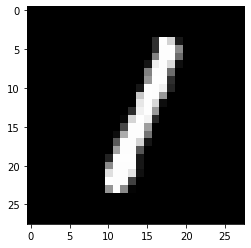

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms 
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
is_cuda = False
if torch.cuda.is_available():
  is_cuda = True

transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('data/',train=True,transform=transformation,download=True) 
test_dataset = datasets.MNIST('data/',train=False,transform=transformation,download=True)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)
sample_data = next(iter(train_loader))

def plot_img(image):
  image = image.numpy()[0]
  mean = 0.1307
  std = 0.3081
  image = ((mean * image) + std) 
  plt.imshow(image,cmap='gray')

plot_img(sample_data[0][2]) 
plot_img(sample_data[0][1])
# (1) 화면 출력 확인

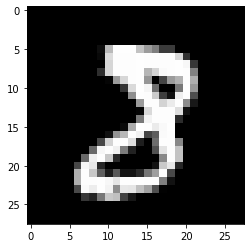

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5) 
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
    self.conv2_drop = nn.Dropout2d(p=0.1) 
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) 
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    #x = F.dropout(x,p=0.1, training=self.training)

    x = self.fc2(x)
    return F.log_softmax(x,dim=1)
    

model = Net() 
if is_cuda:
  model.cuda()

optimizer = optim.SGD(model.parameters(),lr=0.001) 
data , target = next(iter(train_loader))
output = model(Variable(data.cuda()))
print(data.size()) #[batch_size, channels, height, width]
print(data)
print(output.size())
print(output)
print(target.size())
print(target)
# (2) output.size() , target.size() 출력 확인

torch.Size([32, 1, 28, 28])
tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]

In [ ]:

def fit(epoch,model,data_loader,phase='training',volatile=False):
  if phase == 'training':
    model.train()
  if phase == 'validation':
    model.eval()
    volatile=True
  running_loss = 0.0
  running_correct = 0
  for batch_idx , (data,target) in enumerate(data_loader):
    if is_cuda:
      data,target = data.cuda(),target.cuda()
      data , target = Variable(data,volatile),Variable(target)
    if phase == 'training':
      optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output,target)

    running_loss += F.nll_loss(output,target,size_average=False).data
    preds = output.data.max(dim=1,keepdim=True)[1]
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
    if phase == 'training':
      loss.backward()
      optimizer.step()
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
  print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
  return loss, accuracy

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
  epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
  val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
  
  train_losses.append(epoch_loss)
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

# (3) 화면 출력 확인


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.06 and training accuracy is 58919/60000      98.2
validation loss is 0.049 and validation accuracy is 9849/10000     98.49
training loss is 0.061 and training accuracy is 58881/60000     98.14
validation loss is 0.045 and validation accuracy is 9855/10000     98.55
training loss is 0.058 and training accuracy is 58939/60000     98.23
validation loss is 0.046 and validation accuracy is 9849/10000     98.49
training loss is 0.058 and training accuracy is 58937/60000     98.23
validation loss is 0.045 and validation accuracy is 9858/10000     98.58
training loss is 0.057 and training accuracy is 58917/60000     98.19
validation loss is 0.044 and validation accuracy is 9856/10000     98.56
training loss is 0.057 and training accuracy is 59004/60000     98.34
validation loss is 0.043 and validation accuracy is 9856/10000     98.56
training loss is 0.056 and training accuracy is 58973/60000     98.29
validation loss is 0.044 and validation accuracy is 9861/10000     98.61

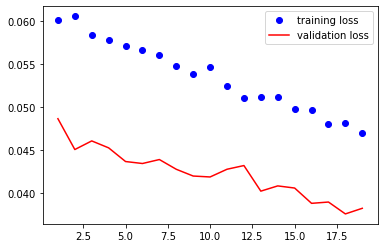

In [ ]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss') 
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss') 
plt.legend()

# (4) 화면 출력 확인

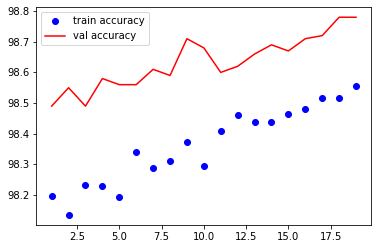

In [ ]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy') 
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy') 
plt.legend()

# (5) 화면 출력 확인

2. [CNN] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요. (10점) (코드의 해석과 결과의 의미를 작성하세요.)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module): #nn.module 상속받아 클래스Net 정의
  def __init__(self):
    super(Net, self).__init__()
    # 1 input image channel, 6 output channels, 5x5 square convolution kernel 
    self.conv1 = nn.Conv2d(1, 6, 5)
    #필터를 사용하여 하나의 채널이 들어가면 6개의 특징맵을 출력함
    self.conv2 = nn.Conv2d(6, 16, 5)
    # an affine operation: y = Wx + b
    #선형회귀모델 구현
    self.fc1 = nn.Linear(16 * 5 * 5, 120) # 이미지 차원은 5*5
    #위에서 특징맵이 16채널이 나옴 , 특징맵의 면적 5*5/
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    #최종으로 10개의 score를 출력

  def forward(self, x):
    #2.2 크기 윈도우에 대해 맥스풀링
    #최대값을 뽑아주는 max pooling - overfitting 방지하기 위함
    # Max pooling over a (2, 2) window
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    #x를 self.conv1을 통과시켜줌->relu통과->maxpool(2*2의 윈도우크기를가지고)->절반으로 줄어드는 결과
    # If the size is a square you can only specify a single number 
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    #self.conv2통과- - > (2,2)를 2로 특정가능
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    #flat한 값(fully connected layer 통과가능)을 fc1->relu통과
    x = F.relu(self.fc2(x))
    #fc2->relu통과
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:] # all dimensions except the batch dimension 
    #배치차원 제외한 모든 차원
    num_features = 1
    for s in size:
      num_features *= s 
    return num_features

net = Net() 
#net이라는 신경망 정의함 
print(net)
# (1) 정의된 컨볼루션 신경망의 구조 설명 (위의 AlexNet 그림 참고)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# net.parameters()를 사용하여 정의된 신경망의 학습가능한 매개변수들을 확인할 수 있음
params = list(net.parameters()) 
print(len(params))
print(params[0].size()) # conv1's .weight
#conv필터의 면적이 5*5이고,입력이미지가 1채널, 출력채널수가 6
# (2) 화면 출력 확인

10
torch.Size([6, 1, 5, 5])


In [ ]:
# 다음의 임의의 32*32 입력을 가정함
# 참고로 크기가 다른 입력을 받을 때는 입력의 크기를 재조정하거나 신경망 수정함
input = torch.randn(1, 1, 32, 32) 
#사이즈만 맞는 이미지형태의 가짜값을 인풋형태로 넣어줌, 32*32 1채널 넣어줌, 배치=1
out = net(input)
print(out)
# (3) 화면 출력 확인

tensor([[ 0.0350,  0.0949, -0.0960,  0.0580,  0.1096, -0.0543, -0.0005,  0.0341,
          0.0763, -0.0280]], grad_fn=<AddmmBackward>)


In [ ]:
# 오류역전파를 통해 그레이디언트를 구하기 전에 모든 가중치의 그레이디언트 버퍼들을 초기화
# cnn네트워크 학습하기 전에는 zero_grad해줘야함 . 그레디언트가 누적이되기때문
net.zero_grad() 
# 랜덤값으로 역전파
out.backward(torch.randn(1, 10))

#LOSS FUNCTION
#손실함수는 output,target 을 한쌍으로 입력받아 output이 target으로부터
#얼마나 멀리 떨어져있는지(틀렸는지) 추정
# 손실 함수 정의 및 임의의 값들에 대해서 오차 결과 확인
# nn 패키지는 많이 사용되는 손실함수들을 제공하며, 해당 예제는 단순한 MSE 를 사용
output = net(input)
target = torch.randn(10) # a dummy target, for example
#print(target) #랜덤값 들어있음 
target = target.view(1, -1) # make it the same shape as output 
#shape을 아웃풋값과 같게 만들어줌 
#print(target)
criterion = nn.MSELoss()
#손실함수계산 함수 정의 (평균제곱오차를 계산)
loss = criterion(output, target) 
print(loss)
# (4) 화면 출력 확인

tensor(1.0472, grad_fn=<MseLossBackward>)


In [ ]:
# 앞에 코드에서 언급한 것과 같이 오류 역전파하기 전, 그레이디언트를 초기화해야 함
# backward() 수행 후 어떤 변화가 있는지 확인하고, 초기화의 필요성을 확인함
net.zero_grad() # zeroes the gradient buffers of all parameters 
#기존의 변화도를 없애는 작업
print('conv1.bias.grad before backward') 
print(net.conv1.bias.grad)
#zero_grad했기때문에 0으로 나옴 
loss.backward()
print('conv1.bias.grad after backward') 
print(net.conv1.bias.grad)
# (5) backward 전,후 화면 출력 확인

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0070, -0.0009, -0.0066,  0.0226, -0.0015, -0.0025])


In [ ]:
# 스토캐스틱 경사하강법 ( (미래)가중치 = (현재)가중치 – 학습률 * 그레이디언트 )을 이용하여 
#가중치 갱신하는 코드는 다음과 같음
learning_rate = 0.01
for f in net.parameters():
  f.data.sub_(f.grad.data * learning_rate)


# 하지만 위 구현 코드보다 실제, torch.optim 에서 구현되는 SDG, Adam, RMSProp 등을 사용함
# 오류 역전파에서 최적화하는 방법을 보인 예제 코드 
import torch.optim as optim
# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)
#optimizer SGD 사용, 파라미터에 대해 옵티마이저 사용(학습할 파라미터 넣어줌)
#lr 학습률은 0.01

# in your training loop:
optimizer.zero_grad() # zero the gradient buffers 
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step() # Does the update
#가중치 갱신됨 

TypeError: ignored

3. [분류기 학습] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요. (14점) (코드의 해석과 결과의 의미를 작성하세요.)

이미지 분류기 학습하기
다음과 같은 단계로 진행해보겠습니다:

torchvision 을 사용하여 CIFAR10의 학습용 / 시험용 데이터셋을 불러오고, 정규화(nomarlizing)합니다.

합성곱 신경망(Convolution Neural Network)을 정의합니다.

손실 함수를 정의합니다.

학습용 데이터를 사용하여 신경망을 학습합니다.

시험용 데이터를 사용하여 신경망을 검사합니다.

In [ ]:
### 1. 정규화된 CIFAR-10 훈련집합과 테스트집합을 torchvision을 이용하여 적재함
#CIFAR10을 불러오고 정규화하기 
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) #학습데이터를 다운
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2) #랜덤하게 데이터 넣어줘야 학습잘됨
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform) #test데이터 받음
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# (1) 화면 출력 확인

Files already downloaded and verified
Files already downloaded and verified


 deer  bird   dog  bird


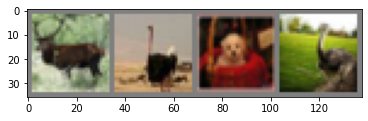

In [ ]:
# 훈련집합의 일부 사진들 확인
import matplotlib.pyplot as plt 
import numpy as np

# functions to show an image 
def imshow(img):
  img = img / 2 + 0.5 # unnormalize 
  npimg = img.numpy() 
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images 
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# (2) 화면 출력 확인

In [ ]:
### 2. 컨볼루션 신경망을 정의함
# 3채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 10 부류를 수행 
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__() 
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) 
    self.conv2 = nn.Conv2d(32, 128, kernel_size=3, padding=1) 
    self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1) 
    self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1) 

    self.pool = nn.MaxPool2d(2, 2) 

    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(128)

    self.gvpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(128 * 4 * 4, 10) 

  def module1(self,x):
    x = F.relu(self.bn1(self.conv3(x)))
    return x

  def module2(self,x):
    x = F.relu(self.bn2(self.conv4(x)))
    return x


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.module1(x)
    x = self.pool(x)
    x = self.module1(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.module2(x)
    x = self.module2(x)
    x = self.module2(x)
    x = self.gvpool(x)
    x = x.view(-1,128*4*4)
    x = self.fc1(x)
    return x

net = Net()
# from torchsummary import summary
# print( summary( net.cuda(), input_size=(3,32,32)))

### 3. 손실함수 정의, 교차 엔트로피와 SGD+momentum
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
### 4. 훈련집합을 이용하여 신경망을 학습시킴 
net.train()
for epoch in range(1): # loop over the dataset multiple times
#트레이닝 데이터셋을 5번 돔.
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs 
    inputs, labels = data

    # zero the parameter gradients 
    #학습시키기 전 필수
    optimizer.zero_grad()

    # forward + backward + optimize 
    # outputs = F.log_softmax(net(inputs))
    outputs = net(inputs)
    loss = criterion(outputs, labels) 
    loss.backward()
    optimizer.step()
    #가중치 갱신 

    # print statistics
    running_loss += loss.item()
    if i % 1000 == 999: # print every 1000 mini-batches
      print('[%d, %5d] loss: %.3f' %
        (epoch + 1, i + 1, running_loss / 1000))
      running_loss = 0.0 
print('Finished Training')
# (3) 화면 출력 확인 및 학습이 되고 있는지 서술

[1,  1000] loss: 1.965
[1,  2000] loss: 1.650
[1,  3000] loss: 1.508
[1,  4000] loss: 1.354
[1,  5000] loss: 1.294
[1,  6000] loss: 1.224
[1,  7000] loss: 1.166
[1,  8000] loss: 1.098
[1,  9000] loss: 1.038
[1, 10000] loss: 1.071
[1, 11000] loss: 0.978
[1, 12000] loss: 0.986
Finished Training


GroundTruth:    cat  ship  ship plane


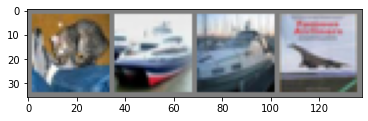

In [ ]:
### 5. 테스트집합을 이용하여 신경망 성능 확인
dataiter = iter(testloader) 
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
# (4) 화면 출력 확인


In [ ]:
net.eval()
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
# (5) 화면 출력 확인
#한개틀리고 세개맞음 

Predicted:    dog  ship  ship  ship


In [ ]:
# performance on the whole test dataset 
# 전체 데이터셋에 대해서 어떻게 동작하는지 확인 
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1) 
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
# (6) 화면 출력 확인 및 일반화 성능 서술

Accuracy of the network on the 10000 test images: 51 %


In [ ]:
# performance on each class 
#클래스에 대해서 어떤것들을 더 잘 분류하고, 어떤것들을 더 못했는지 확인 
class_correct = list(0. for i in range(10)) 
class_total = list(0. for i in range(10)) 
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1) 
    c = (predicted == labels).squeeze() 
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
# (7) 화면 출력 확인 및 부류별 분류기의 성능 서술
  

Accuracy of plane : 18 %
Accuracy of   car : 30 %
Accuracy of  bird : 18 %
Accuracy of   cat : 62 %
Accuracy of  deer : 67 %
Accuracy of   dog : 51 %
Accuracy of  frog : 56 %
Accuracy of horse : 45 %
Accuracy of  ship : 79 %
Accuracy of truck : 86 %


5. 소프트맥스 함수적용

In [ ]:
import torch
import torch.nn.functional as F

data = torch.tensor([0.4, 2.0, 0.001, 0.32])
print(data)
print(F.softmax(data, dim=0))
print(F.softmax(data, dim=0).sum()) 

tensor([4.0000e-01, 2.0000e+00, 1.0000e-03, 3.2000e-01])
tensor([0.1325, 0.6563, 0.0889, 0.1223])
tensor(1.0000)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


6. 목적함수3개 : 평균제곱오차, 교차엔트로피, 로그우드

In [ ]:
import torch.nn as nn
import torch

In [ ]:
########평균제곱오차
input1 = torch.tensor([0.001, 0.9, 0.001, 0.098])
target1 = torch.tensor([0, 0, 0, 1])
criterion = nn.MSELoss()
loss = criterion(input1, target1)
print(loss)

tensor(0.4059)


In [ ]:
########교차엔트로피
# input = torch.tensor([[0.001, 0.9, 0.001, 0.098]])
# target = torch.tensor([3])
# criterion = nn.CrossEntropyLoss()
# loss = criterion(input, target)
# print(loss)

tensor(1.6184)


In [ ]:
########교차엔트로피
import math
input = torch.tensor([0.001, 0.9, 0.001, 0.098])
target = torch.tensor([0, 0, 0, 1])

loss = -((input.log2())*target).sum()

print(loss)

tensor(3.3511)


In [ ]:
########로그우도
import math
input = torch.tensor([0.001, 0.9, 0.001, 0.098])
target = torch.tensor([0, 0, 0, 1])

loss = -((input*target).sum()).log2()
print(loss)

tensor(3.3511)
